# Use VICET to Bound Odometry Errors in LOAM initialized from a moving platform

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-21 15:49:07.353434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:49:07.444687: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-21 15:49:07.834756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-21 15:49:07.834810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-21 15:49:08.503641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:49:08.504394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 15:49:08.504611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 15:49:08.504751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


## Load HD Map from .ply File

In [2]:
import trimesh
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]

print(np.shape(submap))
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Load "Ground Truth" Poses provided in dataset

In [255]:
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #Kitware API specify offset as -134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32)
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)
poses_eul = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# print(poses_eul)

<IPython.core.display.Javascript object>


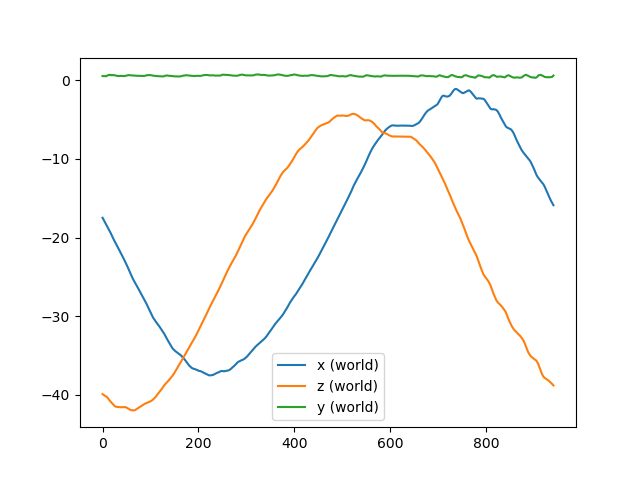

In [256]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
start_idx = 2400
end_idx = 3341

#plot GT
ax.plot(poses[start_idx:end_idx,:3,3], label={'x (world)',"y (world)","z (world)"})
# ax.plot(np.diff(poses[start_idx:end_idx,:3,3], axis = 0), label={'x',"y","z"})
# ax.plot(poses_eul)
# ax.plot(np.diff(poses_eul, axis=0))
ax.legend(loc="best")

## Load LOAM results (starting at arbitrary scan idx) and plot against ground truth

#### NOTE: axis will not be aligned!!!

<IPython.core.display.Javascript object>


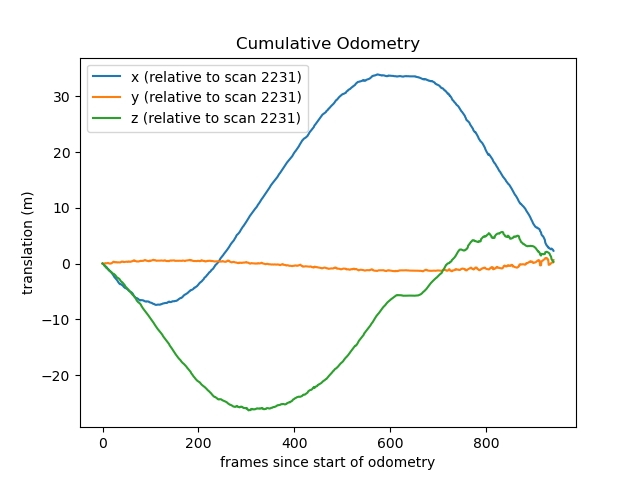

In [541]:
# fn = "results/LOAM/05_test1.npy" #before I got mapmaker working
# fn = "results/LOAM/05_test2.npy" #before I got mapmaker working

# 05_01 after reinstalling EVERYTHING and compiling pcl-1.10 from source
# fn = "results/LOAM/05_test3.npy" # 1650 long 
#makes odom estimates for overall frames 1690-3340 

# # rosbag play --clock -s 54 -r 0.05 rooster_2020-07-10-09-16-39_1.bag 
# fn = "results/LOAM/05_test4.npy" 

# # rosbag play --clock -s 55 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test5.npy" #1100 frames long, starts at 2241 

# start at 2400- very obvious forward motion distortion ()
# rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
fn = "results/LOAM/05_test6.npy" #playback at 0.05x speed
# fn = "results/LOAM/05_test7.npy" #playback at 0.2x speed
# fn_fast = "results/LOAM/05_test8.npy" #playback at 1.0x speed (bad)

LOAM_traj = np.load(fn)
# LOAM_traj = np.diff(np.load(fn), axis = 0)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(LOAM_traj[:,0], label = "x (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,1], label = "y (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,2], label = "z (relative to scan %i)" %start_idx)
ax.set_title("Cumulative Odometry")
ax.set_xlabel("frames since start of odometry")
ax.set_ylabel("translation (m)")
ax.legend(loc="best")

# Plot GT and LOAM in 3D against HD Map 

### TODO: center map about first point in LOAM trajectory

In [542]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [543]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# start_idx = 2400 #overall of GT that corresponds to scan where LOAM begins
# end_idx = #3341
start_idx = 2392
# start_idx = 2241
end_idx = start_idx + len(LOAM_traj) #3341

#draw HD Map -------------------------------------------
# disp.append(Points(submap, c = "grey", r = 2, alpha = 0.1))

submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314

#draw ground truth trajectory -------------------------
# disp.append(Points(gt[start_idx:end_idx,2:5], c = "purple", r=3))#, alpha = 0.2)) #for debug

#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (initial_pose @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
disp.append(Points(gt_lidarframe[start_idx:end_idx,:3], c = "blue", r=3))#, alpha = 0.2))

#draw arrows showand provideding heading
for i in range(start_idx, end_idx,25):
    rot_m = R.from_quat(gt[i,5:]).as_matrix()
    arrow_ends = gt_lidarframe[i,:3] + np.linalg.pinv(rot_m) @ np.eye(3)
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[0,:], c='red'))
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[1,:], c='green'))
    disp.append(Arrow(gt_lidarframe[i,:3], arrow_ends[2,:], c='blue'))

#draw LOAM trajectory ----------------------------------
# disp.append(Points(LOAM_traj[:,:3], c = 'yellow', r = 3, alpha = 0.5))  #raw

# xyz = LOAM_traj[:,:3]
# LOAM_traj_lidarframe = np.array([LOAM_traj[:,0], LOAM_traj[:,1], LOAM_traj[:,2]]).T
LOAM_traj_lidarframe = np.array([LOAM_traj[:,0], LOAM_traj[:,2], LOAM_traj[:,1]]).T
xyz = LOAM_traj_lidarframe[:,:3]
qxyzw = R.from_euler('xyz', LOAM_traj[:,3:]).as_quat() #was this-- sooo close...

num_poses = qxyzw.shape[0]
poses_LOAM = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses_LOAM[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses_LOAM[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
# T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, :3] = R.from_euler('xyz', [0.0, 0., np.deg2rad(134.97 - 15)]).as_matrix() #manually fitting 05_test6 
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #test-flip signs
LOAM_mapframe = np.einsum("nij,jk->nik", poses_LOAM, T_CL)
# disp.append(Points(LOAM_mapframe[:,:3,3], c = 'red', r = 3, alpha = 0.5))

initial_pose_LOAM = np.linalg.pinv(LOAM_mapframe[0])
# print(initial_pose_LOAM)
# print("\n Initial  pose Map: \n", R.from_matrix(initial_pose[:3,:3]).as_euler("xyz"))
# print("\n Initial  pose LOAM: \n", R.from_matrix(initial_pose_LOAM[:3,:3]).as_euler("xyz"))

#draw axis for LOAM
# init_pose_map_euls = R.from_matrix(initial_pose[:3,:3]).as_euler("xyz")
init_pose_map_euls = R.from_matrix(initial_pose_LOAM[:3,:3]).as_euler("xyz")
# init_pose_map_euls[2] += np.deg2rad(45)#test
arrow_end = 3*np.eye(3) @ R.from_euler('xyz', init_pose_map_euls).as_matrix()
disp.append(Arrow([0,0,0], arrow_end[0], c='red'))
disp.append(Arrow([0,0,0], arrow_end[1], c='green'))
disp.append(Arrow([0,0,0], arrow_end[2], c='blue'))

#TODO: need to flip 180 degrees about LOAM frame y axis (remember LIDAR sensor coordinate system is flipped!)
axis = arrow_end[1] #rotate about y
angle = np.deg2rad(180)
LOAM_mapframe2 = (rotation_matrix(axis, angle) @ LOAM_mapframe[:,:3].T).T
disp.append(Points(LOAM_mapframe2[:,:3,3], c = 'purple', r = 3, alpha = 0.5))

plt.show(disp, "LOAM vs Ground Truth")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Let's try that again from scratch

In [673]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]

#init raw LOAM trajectory and OG LOAM axis
LOAM_axis = np.eye(3)
start_idx = 2390
end_idx = start_idx + len(LOAM_traj) #3341
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,0], c = 'red', alpha = 1))
disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,1], c = 'green', alpha = 1))
disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 5*LOAM_axis[:,2], c = 'blue', alpha = 1))
# disp.append(Points([[0.,0,0]], c='red', r =10))

#rotate 135 deg about y axis to align initial motion with +x 
rot_mat = R.from_euler('xyz', [0, np.deg2rad(135), 0]).as_matrix()
# rot_mat = R.from_euler('xyz', [0, np.deg2rad(90), 0]).as_matrix()
LOAM_corr = LOAM_traj[:,:3] @ rot_mat
LOAM_axis = LOAM_axis @ rot_mat
#flip 180 deg
LOAM_corr = np.array([LOAM_corr[:,0], -LOAM_corr[:,2], LOAM_corr[:,1]]).T
LOAM_axis = np.array([LOAM_axis[0,:], -LOAM_axis[2,:], LOAM_axis[1,:]])

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
# gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(180)]).as_matrix() #was this
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [0., 0., np.deg2rad(225)]).as_matrix() #works better
# gt_points = Points(gt_lidarframe[start_idx:end_idx,:3], c = "green", r=3).legend("Ground Truth Trajectory")
# gt_points = Points(gt_lidarframe[start_idx:(start_idx + viewlen),:3], c = "green", r=3).legend("Ground Truth Trajectory")
gt_points = Points(gt_lidarframe[2200:3200,:3], c = "black", r=2).legend("Actual Motion of Platform")
disp.append(gt_points)

#show LOAM corrected
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,0], c = 'red', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,1], c = 'green', alpha = 1.))
# disp.append(Arrow(LOAM_traj[0,:3], LOAM_traj[0,:3] + 3*LOAM_axis[:,2], c = 'blue', alpha = 1.))
# LOAM_pts = Points(LOAM_corr[:,:3], c = 'purple', alpha = 1).legend("LOAM Estimated Trajectory")
LOAM_pts = Points(LOAM_corr[:viewlen,:3], c = 'purple', alpha = 0.5, r = 6).legend("LOAM Estimated Trajectory")
disp.append(LOAM_pts)


#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314


lb = LegendBox([gt_points, LOAM_pts], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left').font("Times New Roman")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

Could set font name Times New Roman -> Using default: Normografo
Check https://vedo.embl.es/fonts for additional fonts
Type 'vedo -r fonts' to see available fonts


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


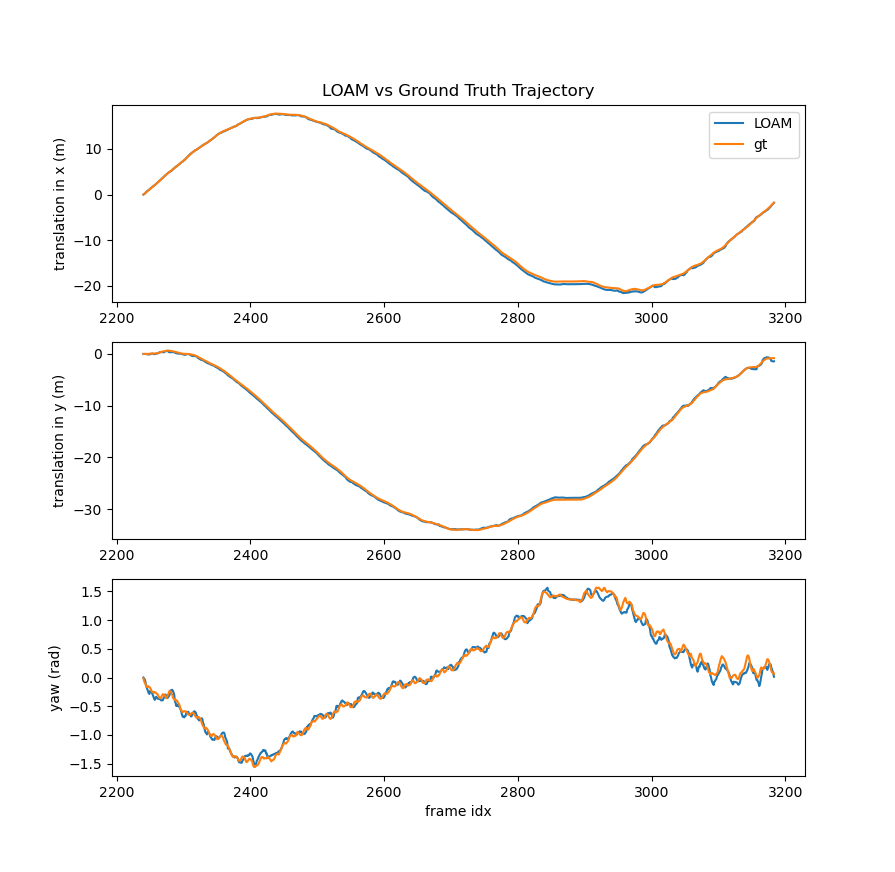

In [809]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3,1)
ax[0].set_title("LOAM vs Ground Truth Trajectory")

x_vec = np.linspace(2240, 2241 + len(LOAM_corr), len(LOAM_corr) )

ax[0].plot(x_vec, LOAM_corr[:,0], label = "LOAM")
ax[0].plot(x_vec, gt_lidarframe[start_idx:end_idx,0], label = "gt")
# ax[0].plot(np.diff(LOAM_corr[:,0]), label = "LOAM")
# ax[0].plot(np.diff(gt_lidarframe[start_idx+1:end_idx,0]), label = "gt")
ax[0].set_ylabel("translation in x (m)")
ax[0].legend(loc='best')
ax[1].set_ylabel("translation in y (m)")
ax[1].plot(x_vec, LOAM_corr[:,1], label = "LOAM")
ax[1].plot(x_vec, gt_lidarframe[start_idx:end_idx,1], label = "gt")

LOAM_yaw = np.arcsin(np.sin(LOAM_traj_euls_fixed[:,1]))
gt_yaw = np.arcsin(np.sin(R.from_quat(gt[:, 5:]).as_euler('xyz')[:,2] + np.deg2rad(105)) )

ax[2].set_xlabel("frame idx")
ax[2].set_ylabel("yaw (rad)")
ax[2].plot(x_vec, LOAM_yaw, label = "LOAM")
ax[2].plot(x_vec, gt_yaw[start_idx:end_idx])

<IPython.core.display.Javascript object>


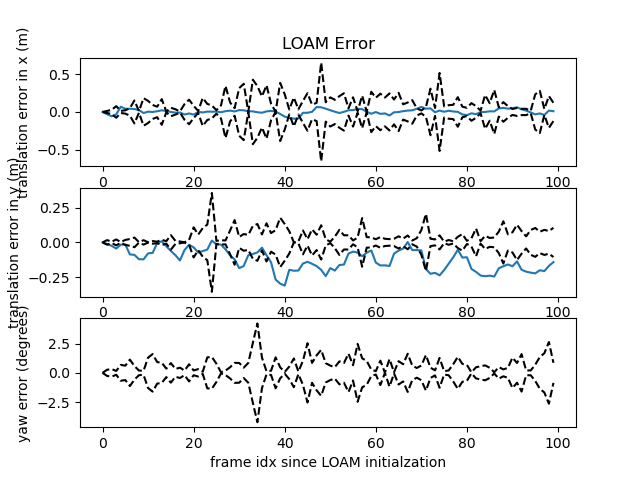

In [810]:
fig, ax = plt.subplots(3,1)
viewlen = 100 #view only this many frames since initialization
# A_hist = np.load("results/LOAM/A_hist_05_test6.npy")

#TODO: transform A_hist from sensor body frame (for each scan) to init body frame
#      this will explain why x is too small, y is too big

ax[0].set_title("LOAM Error")
ax[0].plot(LOAM_corr[:viewlen,0] - gt_lidarframe[start_idx:(start_idx + viewlen),0])
# ax[0].plot(LOAM_corr[10:viewlen,0] - gt_lidarframe[start_idx+10:(start_idx + viewlen),0])
ax[0].plot(abs(A_hist[:100,7])/2, 'k--')
ax[0].plot(-abs(A_hist[:100,7])/2, 'k--')
ax[0].set_ylabel("translation error in x (m)")

ax[1].set_ylabel("translation error in y (m)")
ax[1].plot(LOAM_corr[:viewlen,1] - gt_lidarframe[start_idx:(start_idx+viewlen),1])
# ax[1].plot(LOAM_corr[10:viewlen,1] - gt_lidarframe[start_idx+10:(start_idx+viewlen),1])
ax[1].plot(abs(A_hist[:100,8])/2, 'k--')
ax[1].plot(-abs(A_hist[:100,8])/2, 'k--')

ax[2].set_ylabel("yaw error (degrees)")
ax[2].set_xlabel("frame idx since LOAM initialzation")
ax[2].plot(abs(np.rad2deg(A_hist[:100,11]))/2, 'k--')
ax[2].plot(-abs(np.rad2deg(A_hist[:100,11]))/2, 'k--')

# Use VICET to Estimate Error Bounds (single frame)

In [758]:
#load scans
idx = 2400 #2700 #2650 #2000 - 3000 is the running and swinging loop
# idx = 2400 #very obvious translation distortion
skip = 30 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 10 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# # idx = 116 #slow distortion, very accurate solution
# skip = 3 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

# #COLOR SCAN1 POINTS BY ORDER IN CLOUD
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))

# DRAW SCANS 1 and 2
disp.append(Points(scan1_lidarframe, c = '#a65852', r = 3)) #red
disp.append(Points(scan2_lidarframe, c = '#2c7c94', r = 3)) #blue

disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.1)) ##CB2314
plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [762]:
from linear_corrector import LC
A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
max_buffer = 0.5 #was 2.5

# scan to scan
dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 80, niter = 15, 
        draw = True, mnp = 25, RM = True, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1552: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


LUT tf.Tensor([341   3   3], shape=(3,), dtype=int32)

 residuals (1023, 1)

 delta_A
 (12,)
A: 
 [-0.0573  0.0584  0.0414  0.0219 -0.0162  0.0018] 
 [ 0.0172  0.0323 -0.0212  0.0018  0.0027 -0.0067]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([339   3   3], shape=(3,), dtype=int32)

 residuals (1017, 1)

 delta_A
 (12,)
A: 
 [-0.0575  0.0387 -0.0065  0.0125 -0.0209  0.001 ] 
 [-0.0013  0.097   0.131   0.0358  0.0053 -0.0077]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([339   3   3], shape=(3,), dtype=int32)

 residuals (1017, 1)

 delta_A
 (12,)
A: 
 [-0.0473  0.0211 -0.0128  0.0076 -0.0244 -0.0001] 
 [-0.0226  0.1301  0.1864  0.0506  0.0077 -0.0079]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([340   3   3], shape=(3,), dtype=int32)

 residuals (1020, 1)

 delta_A
 (12,)
A: 
 [-0.04    0.0186 -0.0134  0.0051 -0.0263 -0.0011] 
 [-0.0409  0.1354  0.2128  0.0578  0.0088 -0.0069]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([340   3   3], shape=(3,), dtype=int32)

 resi

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# loop through 100 frame sequence

In [766]:
A_hist = np.zeros([110,12])
viewlen = 100

for i in range(1,viewlen + 1):
    print("\n \n Frame", i, "of 110 \n \n")
    
    #load scans
    idx = 2400 
    skip = i #how many lidar frames between clouds
    # (need to deal with how there are more LIDAR frames than ground truth poses)
    offset = 10 #10 #11  #works best for 05 dataset
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

    # idx = 950 #1080 #950 #fast motion
    # # idx = 116 #slow distortion, very accurate solution
    # skip = 3 #how many lidar frames between clouds
    # offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
    # fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

    pc1 = np.load(fn1)
    pc2 = np.load(fn2)
    #apply homogeneous transform matrix
    scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    # #Rotate scans to align beginning of each scan with +X axis ----------
    # #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    # #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    # #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    # scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
    # scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
    # submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
    # #--------------------------------------------------------------------
    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
    scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]
    
    #run VICET
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5
    dc = LC(cloud1 = scan1_lidarframe, cloud2 = scan2_lidarframe, fid = 80, niter = 15, 
        draw = False, mnp = 25, RM = True, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)
    A_hist[i,:] = dc.A


 
 Frame 1 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([606   3   3], shape=(3,), dtype=int32)

 residuals (1818, 1)

 delta_A
 (12,)
A: 
 [-0.0051 -0.0135 -0.0169 -0.0046 -0.0068  0.0029] 
 [ 0.0047  0.0215  0.0237  0.0108  0.0009 -0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1552: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


LUT tf.Tensor([613   3   3], shape=(3,), dtype=int32)

 residuals (1839, 1)

 delta_A
 (12,)
A: 
 [-0.0067 -0.0208 -0.0182 -0.0062 -0.0078  0.0038] 
 [0.0079 0.0298 0.0368 0.0153 0.0007 0.    ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [-0.0073 -0.0243 -0.0185 -0.0068 -0.0078  0.0042] 
 [0.01   0.0326 0.0425 0.0166 0.0001 0.0009]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [-0.0055 -0.0258 -0.0184 -0.0068 -0.0077  0.0043] 
 [ 0.0087  0.0321  0.044   0.0166 -0.0005  0.0021]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([611   3   3], shape=(3,), dtype=int32)

 residuals (1833, 1)

 delta_A
 (12,)
A: 
 [-0.0039 -0.0269 -0.018  -0.0069 -0.0076  0.0042] 
 [ 0.0071  0.0319  0.0446  0.0166 -0.0009  0.0031]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([610   3   3], shape=(3,), dtype=int32)

 residuals (1830,

LUT tf.Tensor([587   3   3], shape=(3,), dtype=int32)

 residuals (1761, 1)

 delta_A
 (12,)
A: 
 [-0.0343 -0.0572 -0.0297 -0.0004 -0.0112  0.0041] 
 [ 0.0756  0.1078  0.0651  0.0334 -0.0066 -0.002 ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([587   3   3], shape=(3,), dtype=int32)

 residuals (1761, 1)

 delta_A
 (12,)
A: 
 [-0.0422 -0.0606 -0.0287 -0.0005 -0.011   0.0042] 
 [ 0.0889  0.1133  0.0631  0.0333 -0.0069 -0.0021]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([587   3   3], shape=(3,), dtype=int32)

 residuals (1761, 1)

 delta_A
 (12,)
A: 
 [-0.0512 -0.0648 -0.0282 -0.0004 -0.0108  0.0044] 
 [ 0.1034  0.1194  0.062   0.0332 -0.0074 -0.0022]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([585   3   3], shape=(3,), dtype=int32)

 residuals (1755, 1)

 delta_A
 (12,)
A: 
 [-0.0624 -0.0682 -0.027  -0.0005 -0.0107  0.0047] 
 [ 0.1209  0.1258  0.0593  0.0333 -0.0075 -0.0026]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving


 ---checking for moving objects---
LUT tf.Tensor([537   3   3], shape=(3,), dtype=int32)

 residuals (1611, 1)

 delta_A
 (12,)
A: 
 [ 0.0332 -0.0338 -0.0104 -0.0018 -0.0066 -0.0037] 
 [-0.0387  0.0306  0.0357  0.0151 -0.0033  0.0151]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([536   3   3], shape=(3,), dtype=int32)

 residuals (1608, 1)

 delta_A
 (12,)
A: 
 [ 0.0344 -0.0355 -0.0101 -0.0016 -0.0064 -0.0045] 
 [-0.0378  0.032   0.0343  0.0143 -0.0035  0.0165]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([535   3   3], shape=(3,), dtype=int32)

 residuals (1605, 1)

 delta_A
 (12,)
A: 
 [ 0.0332 -0.0369 -0.0101 -0.0015 -0.0064 -0.0051] 
 [-0.0351  0.0335  0.0344  0.0139 -0.0037  0.0176]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([532   3   3], shape=(3,), dtype=int32)

 residuals (1596, 1)

 delta_A
 (12,)
A: 
 [ 0.0321 -0.039  -0.0099 -0.0015 -0.0063 -0.0058] 


 ---checking for moving objects---
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [ 0.0976 -0.2342 -0.0378 -0.019  -0.0048 -0.0294] 
 [-0.0898  0.2704  0.0809  0.0181 -0.0222  0.0202]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [ 0.0944 -0.2452 -0.0361 -0.0191 -0.0048 -0.03  ] 
 [-0.0844  0.284   0.0768  0.0185 -0.0222  0.0204]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([478   3   3], shape=(3,), dtype=int32)

 residuals (1434, 1)

 delta_A
 (12,)
A: 
 [ 0.0899 -0.2502 -0.0347 -0.0191 -0.0046 -0.0302] 
 [-0.0781  0.2916  0.0723  0.0182 -0.0224  0.0203]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([479   3   3], shape=(3,), dtype=int32)

 residuals (1437, 1)

 delta_A
 (12,)
A: 
 [ 0.0877 -0.2595 -0.0334 -0.019  -0.0044 -0.0307] 


 ---checking for moving objects---
LUT tf.Tensor([515   3   3], shape=(3,), dtype=int32)

 residuals (1545, 1)

 delta_A
 (12,)
A: 
 [ 0.1396  0.1824 -0.0842 -0.0229  0.0246 -0.0202] 
 [-0.2359 -0.3437 -0.0318 -0.0466 -0.0053  0.0064]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([512   3   3], shape=(3,), dtype=int32)

 residuals (1536, 1)

 delta_A
 (12,)
A: 
 [ 0.1567  0.1963 -0.0846 -0.0227  0.0246 -0.02  ] 
 [-0.2615 -0.3651 -0.032  -0.0473 -0.0052  0.0061]

 
 Frame 10 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([549   3   3], shape=(3,), dtype=int32)

 residuals (1647, 1)

 delta_A
 (12,)
A: 
 [ 0.0112 -0.0154 -0.0808 -0.0301  0.0083 -0.0031] 
 [ 0.0165 -0.0466 -0.0345 -0.0212 -0.0003 -0.0072]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([560   3   3], shape=(3,), dtype=int32)

 residuals (1680, 1)

 delta_A
 (12,)
A: 
 [ 0.032   0.0083 -0.0778 -0.0307  0.0128 -0.0074] 
 [ 0.0

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([544   3   3], shape=(3,), dtype=int32)

 residuals (1632, 1)

 delta_A
 (12,)
A: 
 [ 0.0629  0.0054 -0.1748 -0.0278 -0.007  -0.0016] 
 [-0.0842 -0.0385  0.0689 -0.0139  0.0201 -0.003 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([588   3   3], shape=(3,), dtype=int32)

 residuals (1764, 1)

 delta_A
 (12,)
A: 
 [ 0.0796  0.0221 -0.1067 -0.0346  0.0027 -0.0024] 
 [-0.0891 -0.0909 -0.063  -0.0339 -0.0057 -0.0039]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([590   3   3], shape=(3,), dtype=int32)

 residuals (1770, 1)

 delta_A
 (12,)
A: 
 [ 0.0862  0.0431 -0.0902 -0.032   0.0096 -0.0023] 
 [-0.0909 -0.1321 -0.0768 -0.0495 -0.0228 -0.0056]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([592   3   3], shape=(3,), dtype=int32)

 residuals (1776, 1)

 delta_A
 (12,)
A: 
 [ 0.0841  0.0589 -0.0978 -0.0302  0.0113 -0.0017] 
 [-0.0952 -0.1499 -0.0456 -0.0553 -0.0279 -0.0078]
~~~~~~~~~~~Iterat

LUT tf.Tensor([572   3   3], shape=(3,), dtype=int32)

 residuals (1716, 1)

 delta_A
 (12,)
A: 
 [ 0.0193  0.0832 -0.1337 -0.0177  0.0107 -0.0082] 
 [-0.0516 -0.1356  0.0179 -0.0249 -0.0112  0.0015]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([570   3   3], shape=(3,), dtype=int32)

 residuals (1710, 1)

 delta_A
 (12,)
A: 
 [ 0.0265  0.0899 -0.1353 -0.0172  0.0112 -0.009 ] 
 [-0.0582 -0.1377  0.024  -0.0263 -0.0125 -0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([569   3   3], shape=(3,), dtype=int32)

 residuals (1707, 1)

 delta_A
 (12,)
A: 
 [ 0.0287  0.0842 -0.1355 -0.0172  0.0113 -0.0094] 
 [-0.06   -0.1275  0.0257 -0.0265 -0.013  -0.0018]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([571   3   3], shape=(3,), dtype=int32)

 residuals (1713, 1)

 delta_A
 (12,)
A: 
 [ 0.03    0.0746 -0.1353 -0.0173  0.0114 -0.009 ] 
 [-0.0592 -0.11    0.026  -0.0263 -0.0132 -0.0042]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([570   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([551   3   3], shape=(3,), dtype=int32)

 residuals (1653, 1)

 delta_A
 (12,)
A: 
 [ 0.0287 -0.0301 -0.1203 -0.0175  0.0111 -0.0099] 
 [-0.0361  0.0329 -0.0125 -0.0359 -0.0054 -0.0112]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([551   3   3], shape=(3,), dtype=int32)

 residuals (1653, 1)

 delta_A
 (12,)
A: 
 [ 0.0316 -0.0322 -0.1194 -0.0176  0.0111 -0.0103] 
 [-0.0389  0.0377 -0.014  -0.036  -0.0056 -0.0114]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([530   3   3], shape=(3,), dtype=int32)

 residuals (1590, 1)

 delta_A
 (12,)
A: 
 [ 0.0309 -0.0361 -0.1187 -0.0175  0.0112 -0.0103] 
 [-0.0384  0.043  -0.017  -0.0361 -0.0056 -0.0117]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([529   3   3], shape=(3,), dtype=int32)

 residuals (1587, 1)

 delta_A
 (12,)
A: 
 [ 0.0319 -0.0403 -0.1181 -0.0175  0.0113 -0.0104] 
 [-0.0398  0.0475 -0.0192 -0.0362 -0.0056 -0.0119]
~~~~~~~~~~~Iteration  1


 ---checking for moving objects---
LUT tf.Tensor([473   3   3], shape=(3,), dtype=int32)

 residuals (1419, 1)

 delta_A
 (12,)
A: 
 [ 0.092  -0.118  -0.1129 -0.0123  0.0078 -0.0151] 
 [-0.116   0.1608 -0.0019 -0.0333 -0.0085 -0.008 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([470   3   3], shape=(3,), dtype=int32)

 residuals (1410, 1)

 delta_A
 (12,)
A: 
 [ 0.0985 -0.1244 -0.113  -0.0123  0.0077 -0.0168] 
 [-0.1242  0.1674 -0.0014 -0.0333 -0.0084 -0.0061]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([468   3   3], shape=(3,), dtype=int32)

 residuals (1404, 1)

 delta_A
 (12,)
A: 
 [ 0.0952 -0.1347 -0.113  -0.0123  0.0077 -0.0171] 
 [-0.1166  0.1801 -0.0022 -0.0334 -0.0082 -0.0066]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([469   3   3], shape=(3,), dtype=int32)

 residuals (1407, 1)

 delta_A
 (12,)
A: 
 [ 0.093  -0.1466 -0.1126 -0.0123  0.0076 -0.0173] 


 ---checking for moving objects---
LUT tf.Tensor([413   3   3], shape=(3,), dtype=int32)

 residuals (1239, 1)

 delta_A
 (12,)
A: 
 [ 0.1526 -0.0675 -0.0465 -0.007   0.0172 -0.0104] 
 [-0.1891  0.134  -0.2196 -0.0455  0.007  -0.0048]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([413   3   3], shape=(3,), dtype=int32)

 residuals (1239, 1)

 delta_A
 (12,)
A: 
 [ 0.1595 -0.0788 -0.0471 -0.0072  0.0169 -0.0104] 
 [-0.1952  0.1478 -0.2182 -0.0448  0.0077 -0.0054]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([414   3   3], shape=(3,), dtype=int32)

 residuals (1242, 1)

 delta_A
 (12,)
A: 
 [ 0.1652 -0.09   -0.0475 -0.0075  0.0165 -0.0099] 
 [-0.1972  0.1618 -0.217  -0.0438  0.0085 -0.0071]

 
 Frame 21 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([354   3   3], shape=(3,), dtype=int32)

 residuals (1062, 1)

 delta_A
 (12,)
A: 
 [-0.0338  0.0315 -0.


 ---checking for moving objects---
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.1304 -0.2111 -0.0691 -0.0237  0.019  -0.0088] 
 [ 0.236   0.3713 -0.206  -0.0468 -0.0138 -0.0033]

 
 Frame 23 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residuals (867, 1)

 delta_A
 (12,)
A: 
 [-0.0739  0.0133 -0.1336 -0.0452  0.0034  0.0004] 
 [ 0.042   0.0414 -0.0129  0.0139  0.0062 -0.0071]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0864  0.0442 -0.084  -0.0397  0.009   0.0009] 
 [ 0.0896  0.0252 -0.1753 -0.0157 -0.0014 -0.0127]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([329   3   3], shape=(3,), dtype=int32)

 residuals (987, 1)

 delta_A
 (12,)
A: 
 [-0.0968  0.0587 -0.0725 -0.0351  0.0141  0.0027] 
 [ 0.134   0.0241 -0.218  -0.0302 -0.0096 -0.01

LUT tf.Tensor([288   3   3], shape=(3,), dtype=int32)

 residuals (864, 1)

 delta_A
 (12,)
A: 
 [-0.048   0.0184 -0.1527 -0.0063  0.0232 -0.0071] 
 [ 0.054   0.0751 -0.0485 -0.0294 -0.0048 -0.0148]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([290   3   3], shape=(3,), dtype=int32)

 residuals (870, 1)

 delta_A
 (12,)
A: 
 [-0.0401  0.0166 -0.1549 -0.0043  0.024  -0.0078] 
 [ 0.0665  0.0913 -0.0628 -0.0346 -0.005  -0.0181]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residuals (876, 1)

 delta_A
 (12,)
A: 
 [-0.0353  0.0171 -0.1577 -0.0038  0.0246 -0.0077] 
 [ 0.0741  0.095  -0.0551 -0.0358 -0.0065 -0.0199]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([291   3   3], shape=(3,), dtype=int32)

 residuals (873, 1)

 delta_A
 (12,)
A: 
 [-0.0361  0.0182 -0.1679 -0.0041  0.0258 -0.0077] 
 [ 0.0847  0.1002 -0.0365 -0.0352 -0.0086 -0.0211]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([292   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0232 -0.2226 -0.0608 -0.0011 -0.0162 -0.0202] 
 [ 0.1141  0.5129  0.0506  0.0098  0.0059 -0.0014]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-0.0294 -0.2675 -0.0529 -0.0018 -0.0179 -0.0193] 
 [ 0.1617  0.5818  0.0388  0.0119  0.0087 -0.0086]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0418 -0.3011 -0.0461 -0.0018 -0.0189 -0.0185] 
 [ 0.1994  0.6372  0.03    0.0125  0.0101 -0.014 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([222   3   3], shape=(3,), dtype=int32)

 residuals (666, 1)

 delta_A
 (12,)
A: 
 [-0.0436 -0.3072 -0.0424 -0.0018 -0.0195 -0.0198] 
 [ 0.1953  0.6466  0.0314  0.0134  0.0102 -0.0121]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving obj


 ---checking for moving objects---
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.0731  0.0875 -0.0754 -0.0002 -0.0293 -0.0082] 
 [ 0.129   0.1472  0.2509  0.0508  0.0001 -0.0229]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([279   3   3], shape=(3,), dtype=int32)

 residuals (837, 1)

 delta_A
 (12,)
A: 
 [-0.084   0.0966 -0.0793 -0.0012 -0.0296 -0.0086] 
 [ 0.1458  0.1384  0.2739  0.0538 -0.0009 -0.0229]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.0972  0.1056 -0.0826 -0.0019 -0.0299 -0.0084] 
 [ 0.1637  0.1293  0.2892  0.0561 -0.0013 -0.024 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([277   3   3], shape=(3,), dtype=int32)

 residuals (831, 1)

 delta_A
 (12,)
A: 
 [-0.1119  0.1118 -0.0846 -0.0024 -0.0301 -0.0085] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([325   3   3], shape=(3,), dtype=int32)

 residuals (975, 1)

 delta_A
 (12,)
A: 
 [-0.0068 -0.392   0.002  -0.0015 -0.0216  0.0004] 
 [-0.0119  0.711   0.1238  0.0425  0.0146 -0.0158]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [ 0.0061 -0.4081  0.0034 -0.0017 -0.0219 -0.001 ] 
 [-0.0386  0.7124  0.1225  0.043   0.0152 -0.0135]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([319   3   3], shape=(3,), dtype=int32)

 residuals (957, 1)

 delta_A
 (12,)
A: 
 [ 0.0194 -0.4185  0.0047 -0.0018 -0.0222 -0.002 ] 
 [-0.0646  0.7163  0.1216  0.0432  0.0156 -0.0122]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([320   3   3], shape=(3,), dtype=int32)

 residuals (960, 1)

 delta_A
 (12,)
A: 
 [ 0.0185 -0.4425  0.0052 -0.002  -0.0224 -0.0006] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([326   3   3], shape=(3,), dtype=int32)

 residuals (978, 1)

 delta_A
 (12,)
A: 
 [-0.4251 -0.3541 -0.0004 -0.0048 -0.0231  0.0495] 
 [ 0.5801  0.7819  0.2395  0.0441  0.0015 -0.0834]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([323   3   3], shape=(3,), dtype=int32)

 residuals (969, 1)

 delta_A
 (12,)
A: 
 [-0.4408 -0.4035  0.0008 -0.0047 -0.0233  0.0527] 
 [ 0.6096  0.8533  0.2365  0.0439  0.0019 -0.0894]

 
 Frame 34 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([443   3   3], shape=(3,), dtype=int32)

 residuals (1329, 1)

 delta_A
 (12,)
A: 
 [-0.1023  0.0318  0.1304  0.0051 -0.0308  0.0067] 
 [ 0.024   0.0459 -0.0174  0.0211  0.013  -0.0051]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([433   3   3], shape=(3,), dtype=int32)

 residuals (1299, 1)

 delta_A
 (12,)
A: 
 [-0.1631  0.022   0.0689  0.0009 -0.0315  0.015 ] 
 [ 0.094

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([475   3   3], shape=(3,), dtype=int32)

 residuals (1425, 1)

 delta_A
 (12,)
A: 
 [-0.0877 -0.0169  0.0409  0.0158 -0.0095  0.0051] 
 [ 0.0361  0.1538  0.0794  0.0022 -0.0021 -0.0123]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([462   3   3], shape=(3,), dtype=int32)

 residuals (1386, 1)

 delta_A
 (12,)
A: 
 [-0.1161 -0.0395  0.0001  0.0137 -0.0102  0.0046] 
 [ 0.068   0.2292  0.192   0.0112 -0.0049 -0.0159]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([458   3   3], shape=(3,), dtype=int32)

 residuals (1374, 1)

 delta_A
 (12,)
A: 
 [-0.1362 -0.0734 -0.0143  0.0128 -0.0116  0.0035] 
 [ 0.103   0.2934  0.2319  0.0156 -0.004  -0.0176]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([458   3   3], shape=(3,), dtype=int32)

 residuals (1374, 1)

 delta_A
 (12,)
A: 
 [-0.1525 -0.1112 -0.0269  0.0122 -0.0124  0.0022] 
 [ 0.1365  0.3592  0.2662  0.0186 -0.0034 -0.0185]
~~~~~~~~~~~Iterat

LUT tf.Tensor([465   3   3], shape=(3,), dtype=int32)

 residuals (1395, 1)

 delta_A
 (12,)
A: 
 [-0.0897  0.0963  0.0706 -0.0044 -0.0221  0.0076] 
 [-0.0161 -0.0014  0.1015  0.0344 -0.0008 -0.0116]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([463   3   3], shape=(3,), dtype=int32)

 residuals (1389, 1)

 delta_A
 (12,)
A: 
 [-0.086   0.1017  0.0586 -0.0044 -0.0233  0.008 ] 
 [-0.0203 -0.0065  0.1309  0.0359  0.0007 -0.0144]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([464   3   3], shape=(3,), dtype=int32)

 residuals (1392, 1)

 delta_A
 (12,)
A: 
 [-0.0885  0.1042  0.0504 -0.0044 -0.0239  0.0088] 
 [-0.013  -0.0114  0.1518  0.0366  0.0015 -0.0176]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([464   3   3], shape=(3,), dtype=int32)

 residuals (1392, 1)

 delta_A
 (12,)
A: 
 [-0.095   0.1056  0.0447 -0.0042 -0.0241  0.0099] 
 [-0.0026 -0.0171  0.1674  0.0364  0.0012 -0.0213]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([465   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([466   3   3], shape=(3,), dtype=int32)

 residuals (1398, 1)

 delta_A
 (12,)
A: 
 [-0.039  -0.0493 -0.0447  0.0077 -0.0197  0.0003] 
 [-0.0927  0.2715  0.2687  0.0521  0.0143 -0.0059]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([464   3   3], shape=(3,), dtype=int32)

 residuals (1392, 1)

 delta_A
 (12,)
A: 
 [-0.0293 -0.0727 -0.0455  0.0074 -0.0203 -0.0008] 
 [-0.0992  0.3056  0.2719  0.0536  0.0151 -0.0046]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([428   3   3], shape=(3,), dtype=int32)

 residuals (1284, 1)

 delta_A
 (12,)
A: 
 [-0.0144 -0.1048 -0.0482  0.0081 -0.0199 -0.0037] 
 [-0.1152  0.345   0.2784  0.0511  0.0142 -0.0005]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([428   3   3], shape=(3,), dtype=int32)

 residuals (1284, 1)

 delta_A
 (12,)
A: 
 [-0.0008 -0.1386 -0.0439  0.0078 -0.0206 -0.0061] 
 [-0.125   0.3825  0.2699  0.0517  0.0159  0.002 ]
~~~~~~~~~~~Iteration  1


 ---checking for moving objects---
LUT tf.Tensor([420   3   3], shape=(3,), dtype=int32)

 residuals (1260, 1)

 delta_A
 (12,)
A: 
 [-0.0206  0.1179 -0.0047 -0.0003 -0.0024  0.0195] 
 [-0.1307 -0.0746 -0.0671  0.0133  0.021  -0.0299]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([418   3   3], shape=(3,), dtype=int32)

 residuals (1254, 1)

 delta_A
 (12,)
A: 
 [-0.0265  0.1495 -0.006  -0.0007 -0.0029  0.0223] 
 [-0.1271 -0.1221 -0.0652  0.0147  0.0218 -0.0348]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([417   3   3], shape=(3,), dtype=int32)

 residuals (1251, 1)

 delta_A
 (12,)
A: 
 [-0.036   0.1908 -0.0045 -0.0011 -0.0035  0.0259] 
 [-0.1179 -0.1846 -0.0705  0.0159  0.0232 -0.0409]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([419   3   3], shape=(3,), dtype=int32)

 residuals (1257, 1)

 delta_A
 (12,)
A: 
 [-0.051   0.2472 -0.0119  0.     -0.0028  0.0296] 


 ---checking for moving objects---
LUT tf.Tensor([414   3   3], shape=(3,), dtype=int32)

 residuals (1242, 1)

 delta_A
 (12,)
A: 
 [-0.0989  0.2112 -0.0608 -0.0152 -0.0105  0.0243] 
 [ 0.0171 -0.2172  0.1572  0.0212  0.0023 -0.0307]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([406   3   3], shape=(3,), dtype=int32)

 residuals (1218, 1)

 delta_A
 (12,)
A: 
 [-0.1105  0.2396 -0.0641 -0.0155 -0.0109  0.0267] 
 [ 0.0065 -0.241   0.1643  0.0226  0.0026 -0.0321]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [-0.1107  0.2655 -0.0652 -0.0162 -0.0114  0.0288] 
 [ 0.0039 -0.266   0.1663  0.0252  0.0034 -0.0346]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([400   3   3], shape=(3,), dtype=int32)

 residuals (1200, 1)

 delta_A
 (12,)
A: 
 [-0.1063  0.2875 -0.0682 -0.016  -0.0115  0.0301] 


 ---checking for moving objects---
LUT tf.Tensor([373   3   3], shape=(3,), dtype=int32)

 residuals (1119, 1)

 delta_A
 (12,)
A: 
 [ 0.0169  0.2224 -0.0916 -0.0065 -0.0053  0.0236] 
 [-0.1459 -0.1919  0.1925  0.0192 -0.0047 -0.0268]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([379   3   3], shape=(3,), dtype=int32)

 residuals (1137, 1)

 delta_A
 (12,)
A: 
 [ 0.0089  0.2197 -0.0903 -0.0076 -0.0067  0.0248] 
 [-0.1241 -0.1918  0.1887  0.0233 -0.002  -0.0297]

 
 Frame 47 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([411   3   3], shape=(3,), dtype=int32)

 residuals (1233, 1)

 delta_A
 (12,)
A: 
 [-0.0453  0.0079 -0.0568 -0.0119  0.0006  0.0043] 
 [-0.0169  0.019  -0.0064  0.007   0.0056 -0.0061]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([408   3   3], shape=(3,), dtype=int32)

 residuals (1224, 1)

 delta_A
 (12,)
A: 
 [-0.047   0.0125 -0.0706 -0.0115  0.      0.0046] 
 [-0.0

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([403   3   3], shape=(3,), dtype=int32)

 residuals (1209, 1)

 delta_A
 (12,)
A: 
 [ 0.0487  0.0485 -0.0947 -0.0326 -0.0042 -0.0016] 
 [-0.0827 -0.0768 -0.0416  0.014   0.0103 -0.0021]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 residuals (1230, 1)

 delta_A
 (12,)
A: 
 [ 0.0715  0.0957 -0.0774 -0.0418 -0.0061 -0.0053] 
 [-0.1312 -0.1597 -0.0393  0.0187  0.0084  0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 residuals (1230, 1)

 delta_A
 (12,)
A: 
 [ 0.0827  0.1417 -0.0721 -0.0407 -0.0051 -0.0085] 
 [-0.1706 -0.2488 -0.0427  0.0126  0.0053  0.002 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 residuals (1212, 1)

 delta_A
 (12,)
A: 
 [ 0.0905  0.1757 -0.0707 -0.0407 -0.0051 -0.0103] 
 [-0.211  -0.3073 -0.0454  0.0125  0.0055  0.0024]
~~~~~~~~~~~Iterat

LUT tf.Tensor([410   3   3], shape=(3,), dtype=int32)

 residuals (1230, 1)

 delta_A
 (12,)
A: 
 [-0.0045  0.0833 -0.1818 -0.0216  0.0172 -0.009 ] 
 [-0.033  -0.1863 -0.0783 -0.0198  0.0018  0.0027]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([406   3   3], shape=(3,), dtype=int32)

 residuals (1218, 1)

 delta_A
 (12,)
A: 
 [-0.0148  0.1079 -0.1813 -0.0196  0.0198 -0.01  ] 
 [-0.0341 -0.2386 -0.0792 -0.0265 -0.003   0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([401   3   3], shape=(3,), dtype=int32)

 residuals (1203, 1)

 delta_A
 (12,)
A: 
 [-0.018   0.1273 -0.1805 -0.0188  0.0209 -0.0108] 
 [-0.0428 -0.2757 -0.081  -0.0295 -0.0049  0.0014]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([402   3   3], shape=(3,), dtype=int32)

 residuals (1206, 1)

 delta_A
 (12,)
A: 
 [-0.0211  0.1437 -0.1805 -0.018   0.0216 -0.0111] 
 [-0.0477 -0.3055 -0.0824 -0.0322 -0.006  -0.    ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([404   3   3], shape=(3,), dtype=int32)

 resi

LUT tf.Tensor([389   3   3], shape=(3,), dtype=int32)

 residuals (1167, 1)

 delta_A
 (12,)
A: 
 [-0.0236  0.3178 -0.2139 -0.0226  0.018   0.0091] 
 [ 0.0284 -0.4623 -0.1008 -0.0311  0.0095 -0.0349]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [-0.0723  0.3574 -0.2137 -0.0225  0.0183  0.0152] 
 [ 0.1002 -0.5099 -0.1027 -0.0319  0.0088 -0.0475]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([391   3   3], shape=(3,), dtype=int32)

 residuals (1173, 1)

 delta_A
 (12,)
A: 
 [-0.1262  0.3896 -0.2136 -0.0233  0.0176  0.0215] 
 [ 0.1839 -0.542  -0.1042 -0.0292  0.01   -0.0611]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([311   3   3], shape=(3,), dtype=int32)

 residuals (933, 1)

 delta_A
 (12,)
A: 
 [-0.149   0.4213 -0.2121 -0.0206  0.021   0.019 ] 
 [ 0.1531 -0.5684 -0.1042 -0.0399  0.0023 -0.0509]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving 


 ---checking for moving objects---
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.3181  0.1745 -0.2265 -0.0207  0.0239  0.0087] 
 [-0.5015 -0.2508 -0.0681 -0.0432 -0.0115 -0.0182]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.3085  0.2085 -0.2268 -0.0204  0.0245  0.01  ] 
 [-0.4775 -0.2788 -0.0671 -0.0444 -0.0129 -0.0193]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([308   3   3], shape=(3,), dtype=int32)

 residuals (924, 1)

 delta_A
 (12,)
A: 
 [ 0.3122  0.2339 -0.2324 -0.0203  0.0246  0.0104] 
 [-0.4778 -0.3061 -0.0532 -0.0445 -0.0133 -0.0196]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([307   3   3], shape=(3,), dtype=int32)

 residuals (921, 1)

 delta_A
 (12,)
A: 
 [ 0.314   0.2565 -0.2364 -0.02    0.0246  0.0114] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([264   3   3], shape=(3,), dtype=int32)

 residuals (792, 1)

 delta_A
 (12,)
A: 
 [-0.0982  0.3669 -0.1547 -0.0018  0.0278  0.0127] 
 [ 0.063  -0.4503 -0.348  -0.0368  0.0111 -0.0391]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([267   3   3], shape=(3,), dtype=int32)

 residuals (801, 1)

 delta_A
 (12,)
A: 
 [-0.0942  0.3613 -0.1532 -0.0022  0.0275  0.0133] 
 [ 0.0563 -0.4348 -0.3472 -0.0359  0.0113 -0.0397]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [-0.0907  0.3543 -0.1527 -0.0024  0.0274  0.0137] 
 [ 0.0581 -0.4242 -0.347  -0.0354  0.0114 -0.0409]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([266   3   3], shape=(3,), dtype=int32)

 residuals (798, 1)

 delta_A
 (12,)
A: 
 [-0.0954  0.3561 -0.1521 -0.0024  0.0274  0.0148] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [-0.1892 -0.2528 -0.1762 -0.008   0.0148 -0.0159] 
 [ 0.3414  0.5302 -0.0725 -0.022   0.0084  0.0082]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [-0.2    -0.2576 -0.1768 -0.0079  0.0148 -0.0171] 
 [ 0.3551  0.5338 -0.0722 -0.022   0.0086  0.0098]

 
 Frame 60 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0131  0.0734 -0.1055 -0.0179  0.008  -0.0005] 
 [ 0.0201 -0.045  -0.0176 -0.0103 -0.0047 -0.0103]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [-0.0102  0.1017 -0.123  -0.0171  0.01   -0.0034] 
 [ 0.0044 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [-0.038   0.0607 -0.1405 -0.0097  0.0113 -0.0025] 
 [ 0.0705 -0.0148 -0.0559 -0.0093  0.0016 -0.0064]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [-0.063   0.0908 -0.1526 -0.008   0.0125 -0.0036] 
 [ 0.1026 -0.0032 -0.0656 -0.0125  0.0016 -0.0107]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([231   3   3], shape=(3,), dtype=int32)

 residuals (693, 1)

 delta_A
 (12,)
A: 
 [-0.0808  0.0865 -0.155  -0.0078  0.0126 -0.0045] 
 [ 0.1303  0.0202 -0.0706 -0.013   0.002  -0.015 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([229   3   3], shape=(3,), dtype=int32)

 residuals (687, 1)

 delta_A
 (12,)
A: 
 [-0.095   0.0676 -0.1604 -0.0066  0.0132 -0.0047] 
 [ 0.1507  0.0461 -0.0756 -0.0157  0.0017 -0.0191]
~~~~~~~~~~~Iteration 

LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0739  0.0388 -0.0892 -0.0184  0.013   0.0066] 
 [-0.1108  0.0579 -0.0389 -0.0172 -0.0243 -0.0229]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0858  0.0165 -0.0847 -0.0194  0.0129  0.0061] 
 [-0.1225  0.0852 -0.0379 -0.015  -0.0249 -0.0238]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.0947 -0.0044 -0.0823 -0.0197  0.0127  0.0054] 
 [-0.1329  0.1085 -0.0376 -0.0144 -0.0249 -0.0237]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0993 -0.0199 -0.0854 -0.0193  0.0116  0.0047] 
 [-0.1479  0.1275 -0.0396 -0.0147 -0.0217 -0.0224]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 0.0628  0.0845  0.1337 -0.0164 -0.0299  0.0096] 
 [-0.0938  0.0993  0.0538  0.0169  0.0013 -0.0174]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([167   3   3], shape=(3,), dtype=int32)

 residuals (501, 1)

 delta_A
 (12,)
A: 
 [ 0.0655  0.0676  0.1305 -0.0171 -0.0301  0.0096] 
 [-0.0922  0.1169  0.051   0.0197  0.0023 -0.0184]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([166   3   3], shape=(3,), dtype=int32)

 residuals (498, 1)

 delta_A
 (12,)
A: 
 [ 0.0625  0.0632  0.1322 -0.0184 -0.0305  0.0099] 
 [-0.0931  0.1216  0.051   0.0227  0.0031 -0.0189]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([169   3   3], shape=(3,), dtype=int32)

 residuals (507, 1)

 delta_A
 (12,)
A: 
 [ 0.0642  0.0552  0.141  -0.0195 -0.0316  0.0102] 
 [-0.092   0.1441  0.0521  0.0253  0.0037


 ---checking for moving objects---
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.1852 -0.0791  0.077   0.0019 -0.0279  0.0066] 
 [ 0.1681  0.3331  0.0171  0.0379  0.019  -0.0297]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([164   3   3], shape=(3,), dtype=int32)

 residuals (492, 1)

 delta_A
 (12,)
A: 
 [-0.186  -0.075   0.0768  0.002  -0.0277  0.0066] 
 [ 0.1676  0.3232  0.018   0.0378  0.0186 -0.0297]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([165   3   3], shape=(3,), dtype=int32)

 residuals (495, 1)

 delta_A
 (12,)
A: 
 [-0.1763 -0.0686  0.0789  0.0014 -0.0281  0.0067] 
 [ 0.1485  0.3132  0.0208  0.039   0.0186 -0.0293]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([168   3   3], shape=(3,), dtype=int32)

 residuals (504, 1)

 delta_A
 (12,)
A: 
 [-0.1562 -0.0581  0.0776  0.0009 -0.0281  0.0044] 
 [ 


 ---checking for moving objects---
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [-0.1826  0.1695  0.1207 -0.0089 -0.0366  0.0062] 
 [ 0.0645  0.0387  0.1789  0.0557  0.017  -0.0219]

 
 Frame 71 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([263   3   3], shape=(3,), dtype=int32)

 residuals (789, 1)

 delta_A
 (12,)
A: 
 [-0.0043  0.1615  0.1753  0.0034 -0.0319  0.0022] 
 [-0.0123 -0.0945  0.058   0.0233  0.0042 -0.0029]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0028  0.2426  0.183  -0.0037 -0.0353 -0.0003] 
 [-0.1413 -0.179   0.0953  0.0411  0.0088  0.0038]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([271   3   3], shape=(3,), dtype=int32)

 residuals (813, 1)

 delta_A
 (12,)
A: 
 [-0.0085  0.3183  0.1427 -0.0038 -0.0336  0.0001] 
 [-0.1675 -0.2573  0.2276  0.0414  0.0003  0.00

LUT tf.Tensor([283   3   3], shape=(3,), dtype=int32)

 residuals (849, 1)

 delta_A
 (12,)
A: 
 [-0.061   0.0956  0.1075  0.0133 -0.0095  0.0054] 
 [-0.0403  0.0743  0.0429  0.0058 -0.0091 -0.0032]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([287   3   3], shape=(3,), dtype=int32)

 residuals (861, 1)

 delta_A
 (12,)
A: 
 [-0.0819  0.1165  0.1047  0.0096 -0.0128  0.0057] 
 [-0.0495  0.0901  0.043   0.021  -0.0036 -0.0031]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.093   0.1273  0.1035  0.0064 -0.0171  0.0055] 
 [-0.0545  0.0979  0.0433  0.0333  0.0043 -0.0034]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([285   3   3], shape=(3,), dtype=int32)

 residuals (855, 1)

 delta_A
 (12,)
A: 
 [-0.1016  0.1354  0.1025  0.0038 -0.0211  0.0059] 
 [-0.0585  0.1042  0.0432  0.0431  0.0114 -0.0049]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([289   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([286   3   3], shape=(3,), dtype=int32)

 residuals (858, 1)

 delta_A
 (12,)
A: 
 [-0.1497  0.2286  0.0433 -0.0111 -0.02    0.0081] 
 [ 0.0207  0.0221  0.0097  0.0338  0.0236 -0.0061]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([280   3   3], shape=(3,), dtype=int32)

 residuals (840, 1)

 delta_A
 (12,)
A: 
 [-0.1676  0.2332  0.0421 -0.0114 -0.0209  0.0079] 
 [ 0.0247  0.0335  0.0091  0.0352  0.0256 -0.0057]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([281   3   3], shape=(3,), dtype=int32)

 residuals (843, 1)

 delta_A
 (12,)
A: 
 [-0.1754  0.2269  0.0418 -0.0125 -0.0222  0.0074] 
 [ 0.0428  0.0455  0.009   0.0397  0.0277 -0.0059]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.1888  0.2136  0.0415 -0.0118 -0.0214  0.0064] 
 [ 0.072   0.0658  0.009   0.0372  0.0263 -0.0057]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving obj


 ---checking for moving objects---
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.1209  0.2418  0.1132  0.0002 -0.0091  0.0134] 
 [-0.008   0.1501  0.0191 -0.0158 -0.0129  0.019 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.141   0.2633  0.1131 -0.0013 -0.0099  0.014 ] 
 [-0.0134  0.1659  0.0191 -0.0104 -0.0122  0.0212]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.1513  0.2829  0.1119 -0.0024 -0.0114  0.0142] 
 [-0.0137  0.1791  0.0174 -0.0059 -0.0091  0.0228]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([247   3   3], shape=(3,), dtype=int32)

 residuals (741, 1)

 delta_A
 (12,)
A: 
 [-0.1652  0.2988  0.1124 -0.0038 -0.0131  0.0142] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.1001  0.2095  0.1241 -0.0083 -0.0345 -0.0041] 
 [-0.1564  0.1289 -0.1201  0.062   0.0508  0.023 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.1131  0.2127  0.1201 -0.0089 -0.0351 -0.0043] 
 [-0.1531  0.1353 -0.1134  0.064   0.0514  0.0242]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([249   3   3], shape=(3,), dtype=int32)

 residuals (747, 1)

 delta_A
 (12,)
A: 
 [-0.1175  0.2101  0.1224 -0.009  -0.0359 -0.005 ] 
 [-0.1467  0.1371 -0.12    0.0647  0.0537  0.025 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([248   3   3], shape=(3,), dtype=int32)

 residuals (744, 1)

 delta_A
 (12,)
A: 
 [-0.1217  0.2145  0.1229 -0.0094 -0.0364 -0.0058] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([236   3   3], shape=(3,), dtype=int32)

 residuals (708, 1)

 delta_A
 (12,)
A: 
 [-0.2396  0.0637  0.1154 -0.0132 -0.0169  0.0044] 
 [ 0.1251  0.2374 -0.0598  0.0121  0.0089  0.0011]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [-0.2341  0.057   0.1152 -0.0136 -0.0173  0.0035] 
 [ 0.128   0.2335 -0.0599  0.0141  0.0095  0.0015]

 
 Frame 82 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([262   3   3], shape=(3,), dtype=int32)

 residuals (786, 1)

 delta_A
 (12,)
A: 
 [-0.0005 -0.0421  0.1094 -0.0066 -0.0135 -0.0019] 
 [-0.119   0.1149  0.0198 -0.0105 -0.004   0.0029]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([265   3   3], shape=(3,), dtype=int32)

 residuals (795, 1)

 delta_A
 (12,)
A: 
 [-0.024  -0.0374  0.1086 -0.0049 -0.0123 -0.0036] 
 [-0.1785 

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.0591  0.0209  0.0252  0.0096 -0.0035  0.0016] 
 [-0.0016  0.0578  0.0032 -0.0127  0.      0.0044]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([245   3   3], shape=(3,), dtype=int32)

 residuals (735, 1)

 delta_A
 (12,)
A: 
 [-0.0884  0.0504  0.0234  0.0104 -0.0019  0.0037] 
 [-0.0196  0.0774  0.0029 -0.0164 -0.0024  0.0054]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([244   3   3], shape=(3,), dtype=int32)

 residuals (732, 1)

 delta_A
 (12,)
A: 
 [-0.1061  0.0721  0.0232  0.0107 -0.0013  0.0046] 
 [-0.0327  0.094   0.0029 -0.0174 -0.0035  0.0062]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([243   3   3], shape=(3,), dtype=int32)

 residuals (729, 1)

 delta_A
 (12,)
A: 
 [-0.1499  0.0616  0.0299  0.0108 -0.0011  0.0032] 
 [ 0.0008  0.1459 -0.0102 -0.0187 -0.0035  0.0088]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], 

LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.1353  0.0482 -0.0644 -0.0161 -0.0097  0.0074] 
 [ 0.0721  0.2136 -0.0409  0.0211  0.0267  0.0023]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [-0.1586  0.0282 -0.0625 -0.0169 -0.0105  0.0069] 
 [ 0.1031  0.2545 -0.043   0.0244  0.0286  0.0023]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([237   3   3], shape=(3,), dtype=int32)

 residuals (711, 1)

 delta_A
 (12,)
A: 
 [-0.1774  0.0101 -0.0638 -0.0179 -0.0134  0.0065] 
 [ 0.1298  0.2878 -0.0458  0.0281  0.0341  0.0017]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.1985 -0.0129 -0.0594 -0.0192 -0.0114  0.0057] 
 [ 0.1718  0.3372 -0.0488  0.0319  0.0305  0.0021]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([211   3   3],

LUT tf.Tensor([238   3   3], shape=(3,), dtype=int32)

 residuals (714, 1)

 delta_A
 (12,)
A: 
 [-0.1438  0.22   -0.0407 -0.0246 -0.0049  0.0178] 
 [ 0.0184  0.2494 -0.2572  0.0154  0.028   0.0092]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([196   3   3], shape=(3,), dtype=int32)

 residuals (588, 1)

 delta_A
 (12,)
A: 
 [-0.1464  0.223  -0.0412 -0.0249 -0.0047  0.017 ] 
 [ 0.0168  0.2519 -0.258   0.0165  0.0275  0.0097]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [-0.1538  0.2262 -0.0398 -0.0252 -0.0046  0.0168] 
 [ 0.0122  0.2549 -0.2605  0.0173  0.0271  0.01  ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([195   3   3], shape=(3,), dtype=int32)

 residuals (585, 1)

 delta_A
 (12,)
A: 
 [-0.1545  0.2255 -0.0385 -0.0252 -0.0045  0.0161] 
 [ 0.0127  0.2549 -0.2641  0.0175  0.027 


 ---checking for moving objects---
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [-0.1274  0.0717 -0.2275 -0.0144  0.0048 -0.0247] 
 [-0.0682  0.0735 -0.1541  0.0119  0.0319  0.0348]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [-0.1298  0.0775 -0.2345 -0.0144  0.006  -0.0264] 
 [-0.0698  0.0771 -0.1457  0.0125  0.0306  0.0392]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [-0.1295  0.0771 -0.2342 -0.0142  0.0059 -0.0281] 
 [-0.0695  0.0768 -0.1457  0.012   0.0308  0.042 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [-0.1314  0.0802 -0.234  -0.0144  0.0065 -0.0296] 
 [-


 ---checking for moving objects---
LUT tf.Tensor([220   3   3], shape=(3,), dtype=int32)

 residuals (660, 1)

 delta_A
 (12,)
A: 
 [-0.2045 -0.1916 -0.2886 -0.0346  0.0111  0.0076] 
 [ 0.2782  0.0829 -0.1628  0.0232  0.0218 -0.0558]

 
 Frame 93 of 110 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
LUT tf.Tensor([240   3   3], shape=(3,), dtype=int32)

 residuals (720, 1)

 delta_A
 (12,)
A: 
 [-0.0152 -0.0183 -0.2407 -0.0235  0.0028 -0.0069] 
 [-0.0222 -0.0143 -0.0897  0.0191  0.0188  0.0019]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
LUT tf.Tensor([256   3   3], shape=(3,), dtype=int32)

 residuals (768, 1)

 delta_A
 (12,)
A: 
 [-0.0524  0.0121 -0.2446 -0.0343 -0.005  -0.0107] 
 [-0.0402  0.0138 -0.0937  0.0411  0.0328  0.0056]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([257   3   3], shape=(3,), dtype=int32)

 residuals (771, 1)

 delta_A
 (12,)
A: 
 [-0.0677  0.0033 -0.2441 -0.0376 -0.0087 -0.0104] 
 [-0.0519  0.0063 -0.0926  0.055   0.041  -0.00

LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0185  0.1413 -0.3048 -0.0065  0.0223  0.0009] 
 [-0.0108 -0.2002 -0.2319 -0.0061  0.0136 -0.011 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
LUT tf.Tensor([252   3   3], shape=(3,), dtype=int32)

 residuals (756, 1)

 delta_A
 (12,)
A: 
 [-0.0434  0.1929 -0.3049 -0.0062  0.0236  0.002 ] 
 [-0.046  -0.207  -0.2306 -0.0067  0.0104 -0.0118]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residuals (753, 1)

 delta_A
 (12,)
A: 
 [-0.0654  0.2011 -0.3067 -0.0065  0.0231  0.0016] 
 [-0.0726 -0.2221 -0.2297 -0.0062  0.0104 -0.0128]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
LUT tf.Tensor([253   3   3], shape=(3,), dtype=int32)

 residuals (759, 1)

 delta_A
 (12,)
A: 
 [-0.0737  0.1964 -0.3073 -0.0065  0.0228  0.0027] 
 [-0.0838 -0.2364 -0.2285 -0.0058  0.0108 -0.0166]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
LUT tf.Tensor([251   3   3], shape=(3,), dtype=int32)

 residual

LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 0.0907  0.0113 -0.3378 -0.016   0.0298  0.0088] 
 [-0.2172 -0.015  -0.1827 -0.0271 -0.0061 -0.0275]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
LUT tf.Tensor([227   3   3], shape=(3,), dtype=int32)

 residuals (681, 1)

 delta_A
 (12,)
A: 
 [ 0.104   0.0051 -0.3382 -0.0164  0.0291  0.0102] 
 [-0.2405 -0.0241 -0.1825 -0.026  -0.0054 -0.0319]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
LUT tf.Tensor([228   3   3], shape=(3,), dtype=int32)

 residuals (684, 1)

 delta_A
 (12,)
A: 
 [ 0.1212 -0.0001 -0.3385 -0.0172  0.0279  0.0113] 
 [-0.2626 -0.0337 -0.1821 -0.0236 -0.0036 -0.036 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([177   3   3], shape=(3,), dtype=int32)

 residuals (531, 1)

 delta_A
 (12,)
A: 
 [ 0.139  -0.0089 -0.3394 -0.0177  0.0264  0.0119] 
 [-0.2759 -0.0434 -0.1822 -0.0214 -0.0007 -0.0394]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~

 ---checking for moving obj


 ---checking for moving objects---
LUT tf.Tensor([143   3   3], shape=(3,), dtype=int32)

 residuals (429, 1)

 delta_A
 (12,)
A: 
 [-0.0769  0.2478 -0.4356 -0.0058 -0.0305 -0.0204] 
 [-0.0365  0.213   0.2064  0.0029  0.0982  0.0576]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([137   3   3], shape=(3,), dtype=int32)

 residuals (411, 1)

 delta_A
 (12,)
A: 
 [-0.0831  0.2674 -0.4388 -0.0025 -0.0372 -0.0168] 
 [-0.0397  0.2237  0.2069 -0.0004  0.1113  0.0534]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([138   3   3], shape=(3,), dtype=int32)

 residuals (414, 1)

 delta_A
 (12,)
A: 
 [-0.0889  0.2828 -0.443  -0.0019 -0.0464 -0.0134] 
 [-0.0427  0.2313  0.2076  0.0043  0.1299  0.0486]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~

 ---checking for moving objects---
LUT tf.Tensor([134   3   3], shape=(3,), dtype=int32)

 residuals (402, 1)

 delta_A
 (12,)
A: 
 [-0.0864  0.2874 -0.4444 -0.0011 -0.0546 -0.0094] 
 [-

In [768]:
# print(np.save.__doc__)
# np.save("results/LOAM/A_hist_05_test6", A_hist)